In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data Exploration
General Notes:
- The files that do not follow the naming conventions have missing metadata (Root Attributes in h5)

In [ ]:
import h5py
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from roar import ALL_VEHICLES, DATA_DIR, TYRE_CLEAN_NAMES, VEHICLE_CLEAN_NAMES

In [3]:
# Some data cleaning for better usability
all_channel_names = pl.read_csv(DATA_DIR / "Extras" / "all_measurement_channels name.csv")
all_channel_names = all_channel_names.with_columns(
    pl.col("Fahrzeug")
    .str.replace(" ", "")
    .str.split(",")
    .replace(VEHICLE_CLEAN_NAMES)
    .replace({tuple(["alle"]): ALL_VEHICLES}),
    pl.col("Relevanz").cast(pl.Categorical),
)
all_channel_names

Beschreibung,Kanalname,Synonym 1,Synonym 2,Fahrzeug,Relevanz
str,str,str,str,list[str],cat
"""Fzg-CAN - Antrieb""","""Antrieb""",null,null,"[""ID.4""]","""nein"""
"""Fzg-CAN""","""BCM1_Aussen_Temp""",null,null,"[""eGolf"", ""ID.4"", … ""Taycan""]","""ja"""
"""HEAD-CAN - labCTRL""","""CAN1_labCTRLI_""",null,null,"[""eGolf"", ""ID.4"", … ""Taycan""]","""nein"""
"""HEAD-CAN - labDX""","""CAN1_labDX_B""",null,null,"[""eGolf"", ""ID.4"", … ""Taycan""]","""nein"""
"""SIS - Trailing Edge - K1""","""Ch_1_labV12""","""TrailK1""",null,"[""eGolf"", ""ID.4"", … ""Taycan""]","""ja"""
…,…,…,…,…,…
"""iMAR""","""v_east_CAN_Sig_""",null,null,"[""eGolf"", ""ID.4"", … ""Taycan""]","""ja"""
"""iMAR""","""v_north_CAN_Sig""",null,null,"[""eGolf"", ""ID.4"", … ""Taycan""]","""ja"""
"""iMAR""","""v_up_CAN_Sig_11""","""v_up_CAN_Sig_21""",null,"[""eGolf"", ""ID.4"", … ""Taycan""]","""ja"""


In [4]:
messungen = pl.read_csv(DATA_DIR / "Extras" / "messungen.csv")
messungen

Messtyp,Geschwindigkeit min (km/h),Geschwindigkeit max (km/h),Beschleunigung (m/s2),Abbrev
str,i64,i64,i64,str
"""v1""",45,80,null,"""meas0"""
"""v2""",80,100,null,"""meas1"""
"""v3""",100,120,null,"""meas2"""
"""a1""",null,null,1,"""meas3"""
"""a2""",null,null,2,"""meas4"""
"""a3""",null,null,3,"""meas5"""


In [5]:
# Does not have a lot of relevance right now -> just load it
strecken = pl.read_csv(DATA_DIR / "Extras" / "strecken.csv")
strecken

ID,Name,GPS,GPS Start,GPS Ende
i64,str,str,str,str
150,"""Unknown Test Track""",null,null,null
211,"""ika Teststrecke""","""50.79101691007796, 6.048780870…","""50.79115036301304, 6.049006938…","""50.790885556264705, 6.04855011…"
259,"""ika - ISO""","""50.79101691007796, 6.048780870…","""50.79115036301304, 6.049006938…","""50.790885556264705, 6.04855011…"


In [6]:
tyre_road_information = pl.read_csv(DATA_DIR / "Extras" / "tyre_road_information.csv")
tyre_road_information = tyre_road_information.with_columns(
    pl.col("Fahrzeug").replace(VEHICLE_CLEAN_NAMES)
)
tyre_road_information

Reifen Nummer,Hersteller,Name,Dimension,Fahrzeug
i64,str,str,str,str
1,"""Continental""","""EcoContact 6 Q ""","""235/55R19 105H""","""ID.4"""
3,"""Uniroyal""","""RainSport 5 ""","""235/55R19 105V""","""ID.4"""
6,"""Continental""","""Premium Contact 6 AO""","""255/50R20 109H""","""Q8"""
10,"""Pirelli""","""P-Zero R""","""275/35R21 103Y""","""Taycan"""
12,"""Hankook""","""Ventus S1 evo3 ev""","""255/50R20 109H""","""Q8"""
13,"""BFGoodrich""","""Summer SRTT""","""225/45R17 94V""","""eGolf"""


In [7]:
vehicle_and_tyre_features = pl.read_csv(DATA_DIR / "Extras" / "vehicle_and_tyre_feature.csv")
vehicle_and_tyre_features = vehicle_and_tyre_features.with_columns(
    pl.col("ReifenID").str.replace_all(r"\D", "").str.to_integer(),
    pl.col("Fahrzeug").replace(VEHICLE_CLEAN_NAMES),
    pl.col("Reifenmodell").replace(TYRE_CLEAN_NAMES),
)

# rename empty or underscore-prefixed columns to feature_0, feature_1, ...
rename_map = {}
feature_idx = 0
for col in vehicle_and_tyre_features.columns:
    if col == "" or (isinstance(col, str) and col.startswith("_")):
        rename_map[col] = f"feature_{feature_idx}"
        feature_idx += 1

if rename_map:
    vehicle_and_tyre_features = vehicle_and_tyre_features.rename(rename_map)

vehicle_and_tyre_features

Fahrzeug,ReifenID,Reifenmodell,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
str,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Q8""",6,"""PremiumContact 6 AO""",2.5,11.9,2324.0,739.8,71.0,6.9,278.15,27.5,6.89,177.0,38.0,38.9,9.56,315.15,68.0,201.5,7.0,14.1
"""Q8""",12,"""Ventus S1 evo 3 ev""",2.5,15.3,2426.0,768.3,72.0,6.3,312.2,31.0,6.98,201.0,51.5,39.2,9.2,312.2,72.0,201.0,6.3,15.3
"""ID.4""",1,"""EcoContact 6 Q""",2.5,11.0,2349.5,747.9,64.5,6.0,262.45,31.9,4.51,173.5,34.5,27.5,6.89,262.45,64.5,173.5,6.0,11.0
"""ID.4""",3,"""RainSport 5""",2.5,11.7,2330.0,741.7,64.5,7.9,258.85,29.8,7.28,173.0,76.5,33.8,7.36,258.85,64.5,173.0,7.9,11.7
"""Taycan""",10,"""P-Zero """,2.4,13.5,2283.5,285.3,69.5,null,320.9,39.2,9.2,207.0,31.5,0.0,0.0,320.9,69.5,207.0,0.0,13.5
"""eGolf""",13,"""Summer SRTT """,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## h5 files

In [8]:
# List all h5 files in the data directory
h5_files = list((DATA_DIR).rglob("*.h5"))
files_df = pl.DataFrame(
    {
        "file_path": h5_files,
        "stem": [f.stem for f in h5_files],
        "vehicle": [file.parent.parent.parent.name for file in h5_files],
        "tyre": [file.parent.name for file in h5_files],
        "track": [file.parent.parent.name for file in h5_files],
        "conventional_naming": [f.stem.startswith("track") for f in h5_files],
    }
)
files_df

file_path,stem,vehicle,tyre,track,conventional_naming
object,str,str,str,str,bool
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas3_2p5_1_2025-08-07_11-28-54.h5,"""track150_ID.4_tyre1_meas3_2p5_…","""ID.4""","""tyre1""","""track150""",true
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas1_2p5_1_2025-08-07_11-23-14.h5,"""track150_ID.4_tyre1_meas1_2p5_…","""ID.4""","""tyre1""","""track150""",true
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas2_2p5_1_2025-08-07_11-25-10.h5,"""track150_ID.4_tyre1_meas2_2p5_…","""ID.4""","""tyre1""","""track150""",true
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas3_2p5_1_2025-08-07_11-27-11.h5,"""track150_ID.4_tyre1_meas3_2p5_…","""ID.4""","""tyre1""","""track150""",true
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas1_2p5_1_2025-08-07_11-22-29.h5,"""track150_ID.4_tyre1_meas1_2p5_…","""ID.4""","""tyre1""","""track150""",true
…,…,…,…,…,…
/Users/moritzfeik/Developer/ROAR/data/Taycan/track211/tyre10/track211_Taycan_tyre10_meas2_2p5_1_2025-09-23_17-05-11.h5,"""track211_Taycan_tyre10_meas2_2…","""Taycan""","""tyre10""","""track211""",true
/Users/moritzfeik/Developer/ROAR/data/Taycan/track211/tyre10/track211_Taycan_tyre10_meas1_2p5_1_2025-09-23_17-00-35.h5,"""track211_Taycan_tyre10_meas1_2…","""Taycan""","""tyre10""","""track211""",true
/Users/moritzfeik/Developer/ROAR/data/Taycan/track211/tyre10/track211_Taycan_tyre10_meas3_2p5_1_2025-09-23_17-08-15.h5,"""track211_Taycan_tyre10_meas3_2…","""Taycan""","""tyre10""","""track211""",true


In [9]:
# Extract measurement and date
files_df = files_df.with_columns(
    pl.when(pl.col("conventional_naming"))
    .then(pl.col("stem").str.extract(r"(meas\d+)", 1))
    .otherwise(
        pl.when(pl.col("stem").str.starts_with("b"))
        .then(
            pl.concat_str(
                [
                    pl.col("stem").str.extract(r"^(b\d+)", 1),
                    pl.lit("_vr"),
                    pl.col("stem").str.extract(r"vr(\d+)", 1),
                ]
            )
        )
        .otherwise(
            pl.concat_str(
                [
                    pl.lit("vr"),
                    pl.col("stem").str.extract(r"vr(\d+)", 1),
                ]
            )
        )
    )
    .alias("masurement"),
    # extract timestamp (as string)
    pl.col("stem")
    .str.extract(r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})", 1)
    .str.strptime(pl.Datetime, "%Y-%m-%d_%H-%M-%S")
    .alias("date"),
)
files_df

file_path,stem,vehicle,tyre,track,conventional_naming,masurement,date
object,str,str,str,str,bool,str,datetime[μs]
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas3_2p5_1_2025-08-07_11-28-54.h5,"""track150_ID.4_tyre1_meas3_2p5_…","""ID.4""","""tyre1""","""track150""",true,"""meas3""",2025-08-07 11:28:54
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas1_2p5_1_2025-08-07_11-23-14.h5,"""track150_ID.4_tyre1_meas1_2p5_…","""ID.4""","""tyre1""","""track150""",true,"""meas1""",2025-08-07 11:23:14
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas2_2p5_1_2025-08-07_11-25-10.h5,"""track150_ID.4_tyre1_meas2_2p5_…","""ID.4""","""tyre1""","""track150""",true,"""meas2""",2025-08-07 11:25:10
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas3_2p5_1_2025-08-07_11-27-11.h5,"""track150_ID.4_tyre1_meas3_2p5_…","""ID.4""","""tyre1""","""track150""",true,"""meas3""",2025-08-07 11:27:11
/Users/moritzfeik/Developer/ROAR/data/ID.4/track150/tyre1/track150_ID.4_tyre1_meas1_2p5_1_2025-08-07_11-22-29.h5,"""track150_ID.4_tyre1_meas1_2p5_…","""ID.4""","""tyre1""","""track150""",true,"""meas1""",2025-08-07 11:22:29
…,…,…,…,…,…,…,…
/Users/moritzfeik/Developer/ROAR/data/Taycan/track211/tyre10/track211_Taycan_tyre10_meas2_2p5_1_2025-09-23_17-05-11.h5,"""track211_Taycan_tyre10_meas2_2…","""Taycan""","""tyre10""","""track211""",true,"""meas2""",2025-09-23 17:05:11
/Users/moritzfeik/Developer/ROAR/data/Taycan/track211/tyre10/track211_Taycan_tyre10_meas1_2p5_1_2025-09-23_17-00-35.h5,"""track211_Taycan_tyre10_meas1_2…","""Taycan""","""tyre10""","""track211""",true,"""meas1""",2025-09-23 17:00:35
/Users/moritzfeik/Developer/ROAR/data/Taycan/track211/tyre10/track211_Taycan_tyre10_meas3_2p5_1_2025-09-23_17-08-15.h5,"""track211_Taycan_tyre10_meas3_2…","""Taycan""","""tyre10""","""track211""",true,"""meas3""",2025-09-23 17:08:15


In [ ]:
import numpy as np


def extract_h5_variables(filename):
    """Extract variable information from an HDF5 file."""
    variables = []

    with h5py.File(filename, "r") as f:

        def collect_datasets(name, obj):
            if isinstance(obj, h5py.Dataset):
                # Get sample_rate from attributes if it exists
                sample_rate = obj.attrs.get("sample_rate", None)
                if isinstance(sample_rate, np.ndarray):
                    sample_rate = sample_rate.astype(np.int32).item()
                else:
                    sample_rate = None

                variables.append(
                    {
                        "variable_name": name,
                        "variable_shape": list(obj.shape),
                        "sample_rate": sample_rate,
                    }
                )

        f.visititems(collect_datasets)

    return variables


def expand_files_with_variables_efficient(files_df, filename_col="file_path"):
    """More efficient version using Polars operations."""
    struct_schema = pl.Struct(
        {
            "variable_name": pl.Utf8,
            "variable_shape": pl.List(pl.Int64),
            "sample_rate": pl.Int32,
        }
    )

    # Apply extraction to each file and explode
    expanded_df = (
        files_df.with_columns(
            pl.col(filename_col)
            .map_elements(extract_h5_variables, return_dtype=pl.List(struct_schema))
            .alias("variables")
        )
        .explode("variables")
        .unnest("variables")
    )

    return expanded_df


files_df_expanded = expand_files_with_variables_efficient(files_df)

In [ ]:
import polars as pl

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)


def plot_h5_analysis(df):
    """Generate comprehensive plots for H5 dataset analysis"""

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # ============ 1. Variable Distribution ============
    ax1 = plt.subplot(3, 3, 1)
    variable_dist = (
        df.group_by("variable_name")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(10)
    )
    ax1.barh(
        variable_dist["variable_name"].to_list(),
        variable_dist["count"].to_list(),
        color="steelblue",
    )
    ax1.set_xlabel("Count")
    ax1.set_title("Top 10 Variables by Frequency", fontweight="bold")
    ax1.invert_yaxis()

    # ============ 2. Sample Rate Distribution ============
    ax2 = plt.subplot(3, 3, 2)
    sample_rate_dist = (
        df.group_by("sample_rate")
        .agg(pl.len().alias("count"))
        .sort("sample_rate")
        .filter(pl.col("sample_rate").is_not_null())
    )
    ax2.bar(
        sample_rate_dist["sample_rate"].to_list(),
        sample_rate_dist["count"].to_list(),
        color="mediumpurple",
        alpha=0.7,
    )
    ax2.set_xlabel("Sample Rate (Hz)")
    ax2.set_ylabel("Count")
    ax2.set_title("Sample Rate Distribution", fontweight="bold")

    # ============ 3. Vehicle Breakdown (Pie Chart) ============
    ax3 = plt.subplot(3, 3, 3)
    vehicle_breakdown = df.group_by("vehicle").agg(pl.len().alias("count"))
    colors = plt.cm.Set3(range(len(vehicle_breakdown)))
    ax3.pie(
        vehicle_breakdown["count"].to_list(),
        labels=vehicle_breakdown["vehicle"].to_list(),
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
    )
    ax3.set_title("Files by Vehicle", fontweight="bold")

    # ============ 4. Files Over Time ============
    ax4 = plt.subplot(3, 3, 4)
    files_over_time = df.group_by("date").agg(pl.len().alias("count")).sort("date")
    ax4.plot(
        range(len(files_over_time)),
        files_over_time["count"].to_list(),
        marker="o",
        linewidth=2,
        markersize=6,
        color="coral",
    )
    ax4.set_xlabel("Date Index")
    ax4.set_ylabel("Number of Files")
    ax4.set_title("Files Collected Over Time", fontweight="bold")
    ax4.grid(True, alpha=0.3)

    # ============ 5. Tyre × Track Heatmap ============
    ax5 = plt.subplot(3, 3, 5)
    tyre_track = df.group_by(["tyre", "track"]).agg(pl.len().alias("count"))
    # Pivot for heatmap
    pivot_data = tyre_track.pivot(values="count", index="tyre", columns="track")
    pivot_array = pivot_data.drop("tyre").to_numpy()

    im = ax5.imshow(pivot_array, cmap="YlOrRd", aspect="auto")
    ax5.set_xticks(range(len(pivot_data.columns[1:])))
    ax5.set_yticks(range(len(pivot_data)))
    ax5.set_xticklabels(pivot_data.columns[1:], rotation=45, ha="right")
    ax5.set_yticklabels(pivot_data["tyre"].to_list())
    ax5.set_title("Tyre × Track Combinations", fontweight="bold")
    plt.colorbar(im, ax=ax5, label="Count")

    # Add text annotations
    for i in range(len(pivot_data)):
        for j in range(len(pivot_data.columns[1:])):
            if not np.isnan(pivot_array[i, j]):
                ax5.text(
                    j,
                    i,
                    int(pivot_array[i, j]),  # type: ignore
                    ha="center",
                    va="center",
                    color="black",
                    fontsize=9,
                )

    # ============ 6. Data Size by Variable ============
    ax6 = plt.subplot(3, 3, 6)
    variable_sizes = (
        df.with_columns(
            pl.col("variable_shape")
            .list.eval(pl.element().product())
            .list.first()
            .alias("total_elements")
        )
        .group_by("variable_name")
        .agg(pl.col("total_elements").sum().alias("total_size"))
        .sort("total_size", descending=True)
        .head(10)
    )
    ax6.barh(
        variable_sizes["variable_name"].to_list(),
        variable_sizes["total_size"].to_list(),
        color="lightcoral",
    )
    ax6.set_xlabel("Total Elements")
    ax6.set_title("Top 10 Variables by Data Size", fontweight="bold")
    ax6.invert_yaxis()
    ax6.ticklabel_format(style="scientific", axis="x", scilimits=(0, 0))

    # ============ 7. Track Distribution ============
    ax7 = plt.subplot(3, 3, 7)
    track_dist = df.group_by("track").agg(pl.len().alias("count")).sort("count", descending=True)
    ax7.bar(range(len(track_dist)), track_dist["count"].to_list(), color="seagreen", alpha=0.7)
    ax7.set_xticks(range(len(track_dist)))
    ax7.set_xticklabels(track_dist["track"].to_list(), rotation=45, ha="right")
    ax7.set_ylabel("Count")
    ax7.set_title("Measurements by Track", fontweight="bold")

    # ============ 8. Tyre Distribution ============
    ax8 = plt.subplot(3, 3, 8)
    tyre_dist = df.group_by("tyre").agg(pl.len().alias("count")).sort("count", descending=True)
    ax8.bar(range(len(tyre_dist)), tyre_dist["count"].to_list(), color="orange", alpha=0.7)
    ax8.set_xticks(range(len(tyre_dist)))
    ax8.set_xticklabels(tyre_dist["tyre"].to_list(), rotation=45, ha="right")
    ax8.set_ylabel("Count")
    ax8.set_title("Measurements by Tyre", fontweight="bold")

    # ============ 9. Summary Statistics Box ============
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis("off")

    stats_text = f"""
    DATASET SUMMARY
    {"=" * 30}
    
    Total Rows: {len(df):,}
    Unique Variables: {df["variable_name"].n_unique()}
    
    Vehicles: {df["vehicle"].n_unique()}
    Tyres: {df["tyre"].n_unique()}
    Tracks: {df["track"].n_unique()}
    
    Sample Rates:
      Min: {df["sample_rate"].min()} Hz
      Max: {df["sample_rate"].max()} Hz
      Mean: {df["sample_rate"].mean():.1f} Hz
    
    Date Range:
      From: {df["date"].min()}
      To: {df["date"].max()}
    """

    ax9.text(0.1, 0.5, stats_text, fontsize=11, family="monospace", verticalalignment="center")

    plt.tight_layout()
    return fig


# Usage:
# fig = plot_h5_analysis(expanded_df)
# plt.show()
# plt.savefig('h5_analysis.png', dpi=300, bbox_inches='tight')


# ============ INDIVIDUAL DETAILED PLOTS ============


def plot_variable_shape_dimensions(df):
    """Plot distribution of variable dimensions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Number of dimensions per variable
    dim_counts = (
        df.with_columns(pl.col("variable_shape").list.len().alias("n_dims"))
        .group_by("n_dims")
        .agg(pl.len().alias("count"))
        .sort("n_dims")
    )

    ax1.bar(dim_counts["n_dims"].to_list(), dim_counts["count"].to_list(), color="teal", alpha=0.7)
    ax1.set_xlabel("Number of Dimensions")
    ax1.set_ylabel("Count")
    ax1.set_title("Distribution of Variable Dimensions", fontweight="bold")

    # Shape size distribution (log scale)
    sizes = df.with_columns(
        pl.col("variable_shape").list.eval(pl.element().product()).list.first().alias("size")
    ).filter(pl.col("size").is_not_null())

    ax2.hist(
        np.log10(sizes["size"].to_list()), bins=30, color="indianred", alpha=0.7, edgecolor="black"
    )
    ax2.set_xlabel("log10(Total Elements)")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Distribution of Variable Sizes (log scale)", fontweight="bold")

    plt.tight_layout()
    return fig


def plot_sample_rate_by_variable(df):
    """Plot sample rates for different variables"""
    fig, ax = plt.subplots(figsize=(12, 6))

    var_sample = (
        df.group_by(["variable_name", "sample_rate"])
        .agg(pl.len().alias("count"))
        .filter(pl.col("sample_rate").is_not_null())
        .sort(["variable_name", "sample_rate"])
    )

    # Get unique variables and sample rates
    variables = var_sample["variable_name"].unique().to_list()[:15]  # Top 15
    var_filtered = var_sample.filter(pl.col("variable_name").is_in(variables))

    # Create scatter plot
    for var in variables:
        var_data = var_filtered.filter(pl.col("variable_name") == var)
        ax.scatter(
            var_data["sample_rate"].to_list(),
            [var] * len(var_data),
            s=var_data["count"].to_list(),
            alpha=0.6,
        )

    ax.set_xlabel("Sample Rate (Hz)")
    ax.set_ylabel("Variable Name")
    ax.set_title("Sample Rates by Variable (bubble size = count)", fontweight="bold")
    ax.grid(True, alpha=0.3, axis="x")

    plt.tight_layout()
    return fig

/var/folders/8h/0y2pf_1n2735m_vsyhnb7lkw0000gn/T/ipykernel_91501/3022675226.py:84: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_data = tyre_track.pivot(values="count", index="tyre", columns="track")


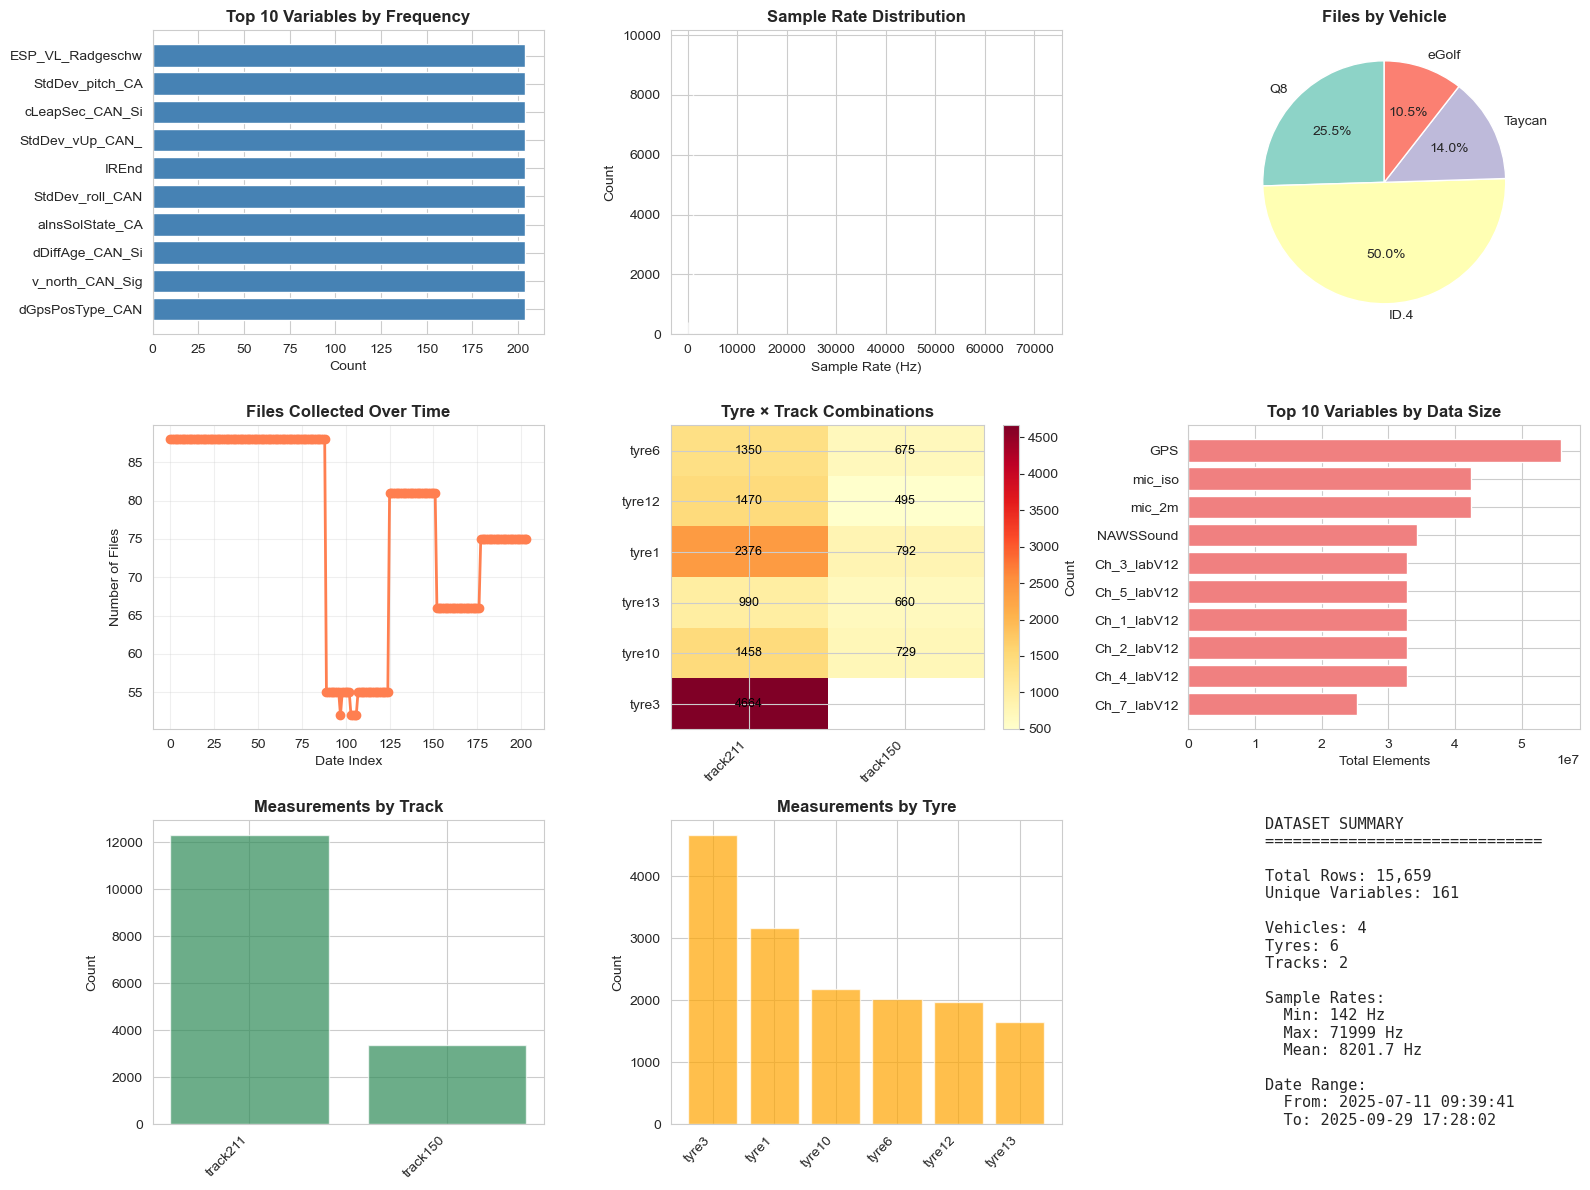

In [ ]:
fig = plot_h5_analysis(files_df_expanded)